# Análisis Bivariado e Inferencial

Este notebook se enfoca en el análisis de relaciones entre variables (bivariado) y pruebas estadísticas inferenciales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo y visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
file_path = 'EV_Energy_Consumption_Cleaned - EV_Energy_Consumption_Cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    print(f"Error: El archivo '{file_path}' no se encontró. Verifica la ruta.")

# Preprocesamiento básico (replicando pasos de EDA)
# Conversión de variables categóricas
cols_to_categorical = ['Driving_Mode', 'Road_Type', 'Traffic_Condition', 'Weather_Condition']
for col in cols_to_categorical:
    if col in df.columns:
        df[col] = df[col].astype('object')

# Seleccionar columnas numéricas para correlación
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"Columnas numéricas detectadas: {len(numeric_cols)}")

Dataset cargado correctamente.
Columnas numéricas detectadas: 13


## 1. Análisis de Correlación y Relaciones Bivariadas

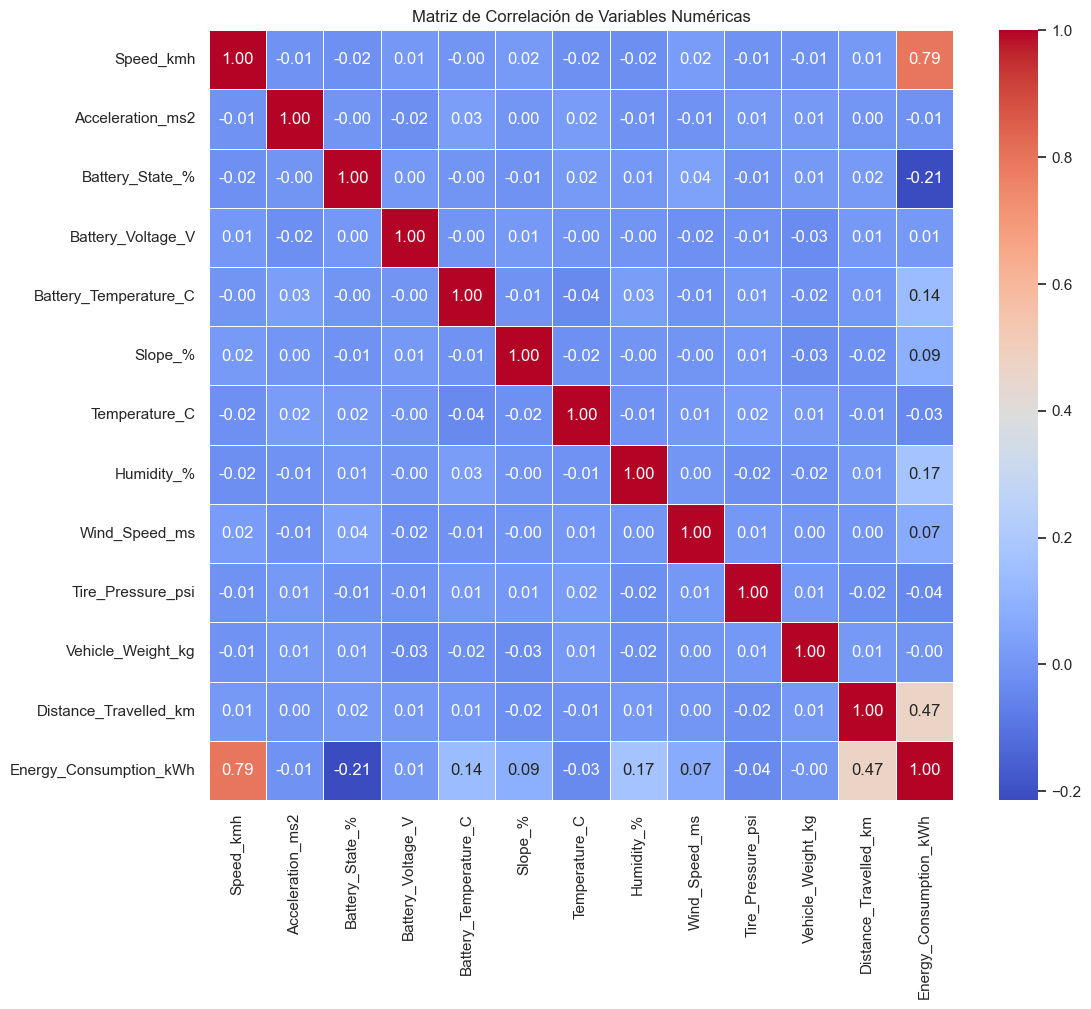

Demasiadas variables para un pairplot completo. Se muestra solo heatmap.


In [2]:
# Matriz de Correlación (Heatmap)
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# Pairplot para visualizar relaciones entre pares de variables
if len(numeric_cols) <= 10:
    sns.pairplot(df[numeric_cols])
    plt.suptitle('Pairplot de Variables Numéricas', y=1.02)
    plt.show()
else:
    print("Demasiadas variables para un pairplot completo. Se muestra solo heatmap.")

## 2. Relación con la Variable Objetivo (Energy_Consumption_kWh)

Se analiza la relación visual entre el consumo de energía (`Energy_Consumption_kWh`) y las variables predictoras seleccionadas: `Battery_State_%`, `Humidity_%`, y `Distance_Travelled_km`.

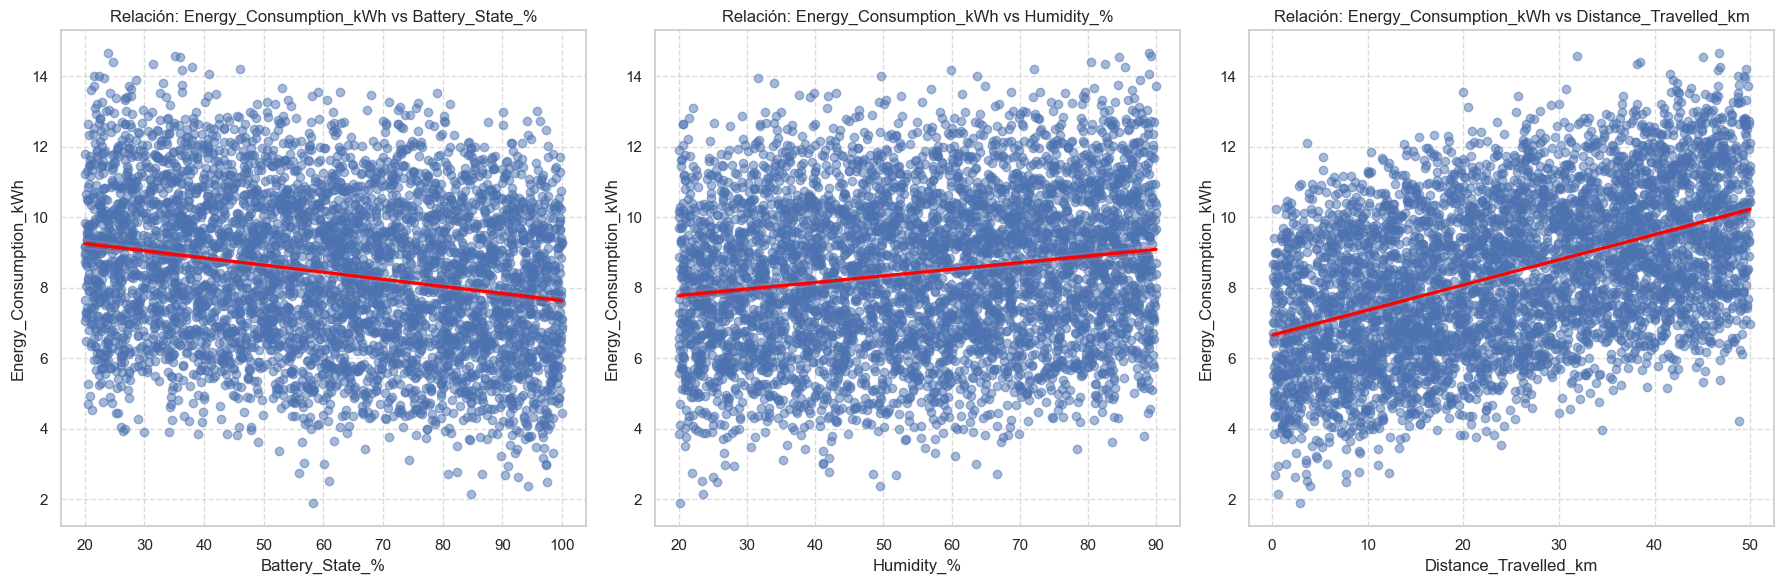

In [3]:
# Variables definidas para el análisis
target_var = 'Energy_Consumption_kWh'
predictor_vars = ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km']

# Verificar que las columnas existan
vars_to_plot = [var for var in predictor_vars if var in df.columns]

if vars_to_plot:
    plt.figure(figsize=(18, 6))
    for i, col in enumerate(vars_to_plot):
        plt.subplot(1, 3, i + 1)
        # Scatterplot con línea de regresión para ver tendencia
        sns.regplot(data=df, x=col, y=target_var, line_kws={"color": "red"}, scatter_kws={'alpha':0.5})
        plt.title(f'Relación: {target_var} vs {col}')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("Las columnas seleccionadas no se encontraron en el dataset.")

## 3. Pruebas de Hipótesis (Correlación de Pearson)

Se evalúa si existe una correlación lineal estadísticamente significativa entre el consumo de energía y cada variable explicativa.

**Hipótesis:**
*   $H_0: \rho = 0$ (No hay correlación)
*   $H_1: \rho \neq 0$ (Existe correlación significativa)

Nivel de significancia $\alpha = 0.05$.

In [4]:
from scipy import stats

print(f"{'Variable':<30} | {'Correlación (r)':<15} | {'P-valor':<15} | {'Resultado'}")
print("-" * 85)

for col in vars_to_plot:
    # Calcular correlación de Pearson y p-valor
    # Nota: dropna() asegura que no falle si hay nulos
    subset = df[[col, target_var]].dropna()
    r, p_value = stats.pearsonr(subset[col], subset[target_var])
    
    # Interpretación
    significativo = "Rechazo H0 (Significativa)" if p_value < 0.05 else "No rechazo H0 (No signif.)"
    
    print(f"{col:<30} | {r:<15.4f} | {p_value:<15.4e} | {significativo}")

Variable                       | Correlación (r) | P-valor         | Resultado
-------------------------------------------------------------------------------------
Battery_State_%                | -0.2138         | 8.4329e-53      | Rechazo H0 (Significativa)
Humidity_%                     | 0.1730          | 6.9116e-35      | Rechazo H0 (Significativa)
Distance_Travelled_km          | 0.4659          | 7.0178e-268     | Rechazo H0 (Significativa)


## 4. Análisis del Efecto del Modo de Conducción (Multivariado)

Se incorpora la variable categórica `Driving_Mode` para evaluar visual y estadísticamente si influye en el consumo de energía (`Energy_Consumption_kWh`) y cómo interactúa con las variables predictoras.


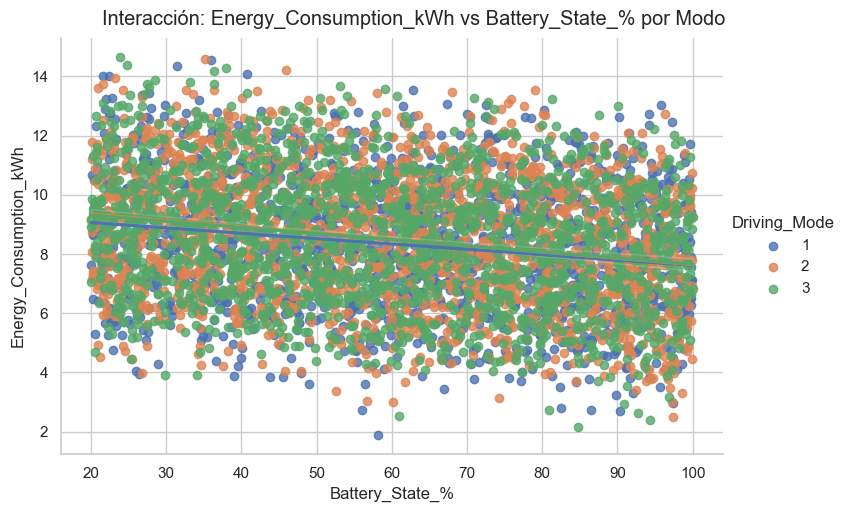

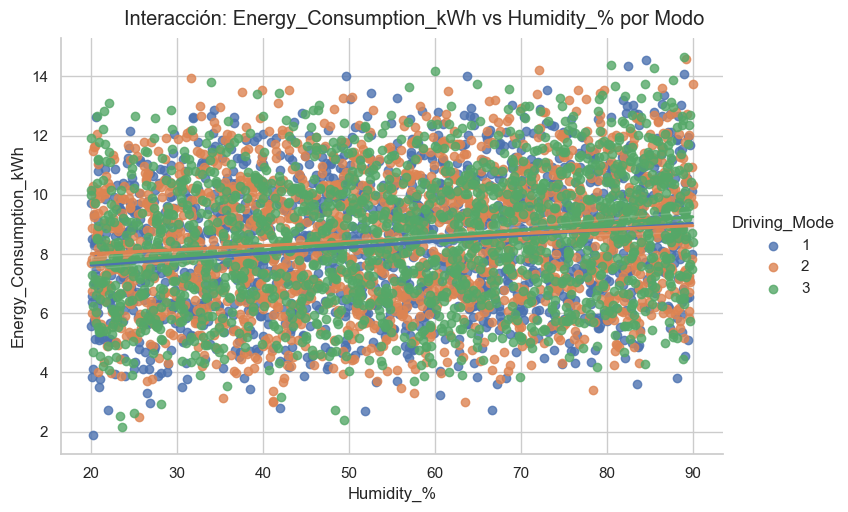

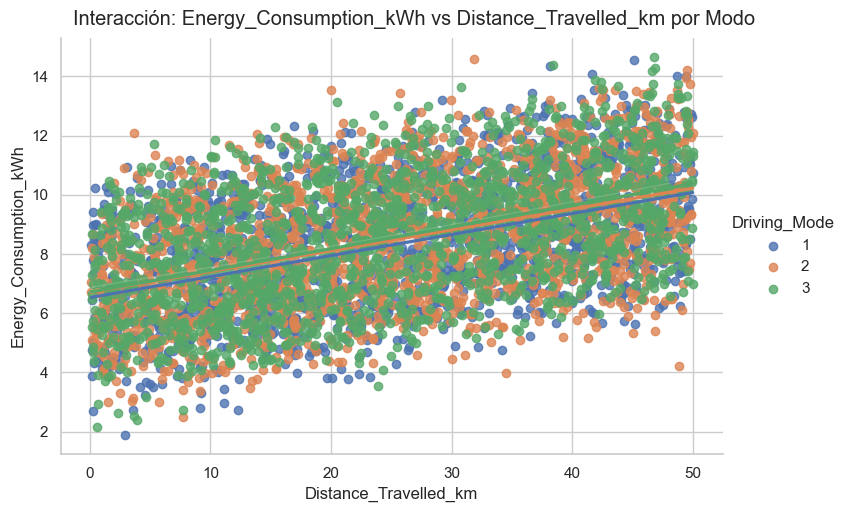

C:\Users\etien\AppData\Local\Temp\ipykernel_19032\128438784.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Driving_Mode', y=target_var, palette="Set2")


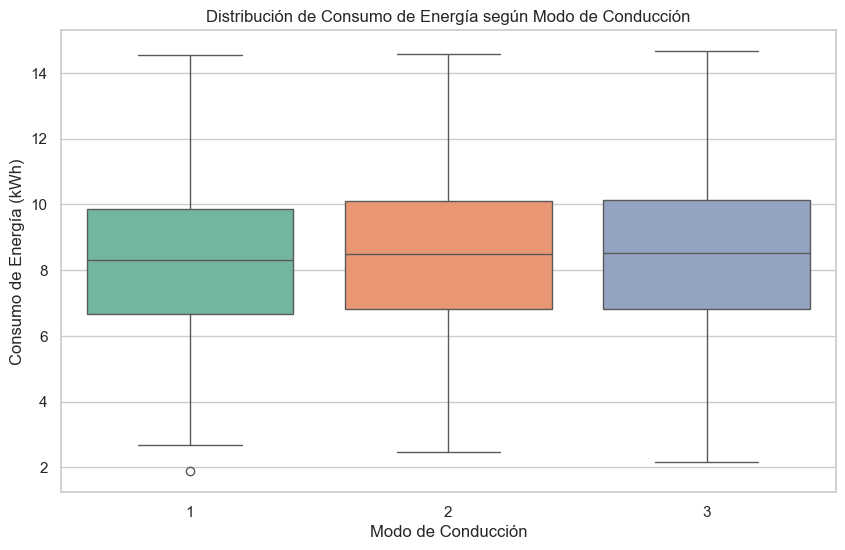

In [5]:
# Visualización de interacciones con el Modo de Conducción
if 'Driving_Mode' in df.columns:
    # 1. Gráficos de dispersión con regresión diferenciada por modo
    # Usamos lmplot que permite separar por 'hue' fácilmente
    for col in vars_to_plot:
        # vars_to_plot viene definido de celdas anteriores
        g = sns.lmplot(data=df, x=col, y=target_var, hue='Driving_Mode', height=5, aspect=1.5)
        g.fig.suptitle(f'Interacción: {target_var} vs {col} por Modo', y=1.02)
        plt.show()

    # 2. Boxplot Comparativo
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Driving_Mode', y=target_var, palette="Set2")
    plt.title('Distribución de Consumo de Energía según Modo de Conducción')
    plt.xlabel('Modo de Conducción')
    plt.ylabel('Consumo de Energía (kWh)')
    plt.show()
else:
    print("La columna 'Driving_Mode' no está presente para el análisis.")


### Prueba ANOVA de un factor

Se utiliza ANOVA (Analysis of Variance) para probar si las medias de consumo de energía son iguales entre los diferentes grupos de `Driving_Mode`.

*   $H_0: \mu_{Eco} = \mu_{Normal} = \mu_{Sport}$ (Las medias son iguales)
*   $H_1:$ Al menos una media es diferente.


In [7]:
from scipy.stats import f_oneway

if 'Driving_Mode' in df.columns:
    print("Resultados del ANOVA (Energy_Consumption_kWh ~ Driving_Mode):")
    print("-" * 60)
    
    # Agrupar los datos: Crear una lista de arrays, uno por cada categoría
    groups = [group[target_var].dropna() for name, group in df.groupby('Driving_Mode')]
    
    # Calcular ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    print(f"{'Estadístico F':<20}: {f_stat:.4f}")
    print(f"{'P-valor':<20}: {p_value:.4e}")
    
    alpha = 0.05
    if p_value < alpha:
        print("\nCONCLUSIÓN: Se rechaza la hipótesis nula.")
        print("Existe una diferencia estadísticamente significativa en el consumo de energía entre los modos de conducción.")
    else:
        print("\nCONCLUSIÓN: No se rechaza la hipótesis nula.")
        print("No hay evidencia suficiente para afirmar que el modo de conducción afecta el consumo medio.")
else:
    print("No se pudo realizar ANOVA: falta variable 'Driving_Mode'.")


Resultados del ANOVA (Energy_Consumption_kWh ~ Driving_Mode):
------------------------------------------------------------
Estadístico F       : 3.4011
P-valor             : 3.3414e-02

CONCLUSIÓN: Se rechaza la hipótesis nula.
Existe una diferencia estadísticamente significativa en el consumo de energía entre los modos de conducción.
